In [23]:
from tqdm import tqdm

In [4]:
import pandas as pd

In [1]:
from tahoe import execute_async

In [5]:
df_tax = pd.read_json('../taxonomy/wish_newtax.json', lines=True)

In [7]:
df_ontology = pd.read_csv('[ontology] wish_top25L2_attributes - 20221219.csv')

In [10]:
l2s = sorted(list(set(df_ontology['wish_L2'])))

In [11]:
len(l2s)

25

In [86]:
reses = []
for i in l2s:
    tmp = df_tax[
        df_tax.category_path.str.startswith(i) & df_tax.is_leaf
    ]
    assert len(tmp) > 0
    for j in tqdm(tmp['id'].tolist()):
        q = f"SELECT listing_id, category_id FROM structured_data.latest_listing_category_predictions WHERE category_id = {j} LIMIT 500"
        # print(q)
        res = execute_async(q)
        # print(res)
        if len(res) > 0:
            reses += res


100%|██████████| 27/27 [01:53<00:00,  4.21s/it]


In [88]:
df_sample = pd.DataFrame(reses, columns=['product_id', 'category_id'])

In [89]:
df_sample.to_csv('tmp.csv', index=False)

In [90]:
df_sample

,product_id,category_id
0,60943c7d75b93744f90c1c13,178
1,609efd6205047d614c61899b,178
2,622b6a9d34c6b0a38849a922,178
3,58e31565d863491c714231a3,178
4,5bbcec1fcc66e367fdb3a56f,178
...,...,...
706445,5f041a1cc8459e089958a321,5945
706446,5c08ebea6ca6f70c65ee5244,5945
706447,6088ee1cf7afd207e3ce32d2,5945
706448,60d598e55abc0048a9fc86d4,5945


In [1]:
from tahoe import create_table, create_external_table, drop_external_table, execute_async
from s3 import temp_bucket, get_s3_file_keys, upload_df_to_parquet
import pandas as pd
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO
)

In [2]:
temp_test_table = {
    "name": "temp_sample_pids",
    "columns": [
        {"name": "product_id", "type": "STRING"},
        {"name": "category_id", "type": "INTEGER"}
    ]
}
db = "sweeper_dev"


In [ ]:

create_external_table(
    table_name=temp_test_table["name"],
    table_definition=temp_test_table,
    db=db,
    bucket=temp_bucket
)

In [96]:
upload_df_to_parquet(df_sample, s3_bucket=temp_bucket, s3_key=f"sweeper_dev/{temp_test_table['name']}/data.parquet")

2022-12-30 03:05:52,191 INFO: Uploading DF (706450, 2) records to sweeper_dev/temp_sample_pids/data.parquet.
2022-12-30 03:05:53,723 INFO: Uploaded DF (706450, 2) to sweeper_dev/temp_sample_pids/data.parquet.


In [97]:
q = f"SELECT COUNT(*) FROM {db}.{temp_test_table['name']}"
execute_async(q)

2022-12-30 03:06:08,040 INFO: SELECT COUNT(*) FROM sweeper_dev.temp_sample_pids


[(706450,)]

In [98]:
q = f"""
SELECT A.id, A.title, A.product_description FROM search.product_document_20221228 A
INNER JOIN {db}.{temp_test_table['name']} B on
A.id = B.product_id
"""

In [99]:
res = execute_async(q)

2022-12-30 03:08:10,057 INFO: 
SELECT A.id, A.title, A.product_description FROM search.product_document_20221228 A
INNER JOIN sweeper_dev.temp_sample_pids B on
A.id = B.product_id



In [100]:
len(res)

40846

In [3]:
drop_external_table(
    db=db,
    table_name=temp_test_table["name"],
    delete_files=True,
    s3_bucket=temp_bucket,
    s3_prefix=f'{db}/{temp_test_table["name"]}', 
)

2022-12-30 03:28:32,018 INFO: USE `default`
2022-12-30 03:28:32,933 INFO: 
    DROP TABLE IF EXISTS sweeper_dev.temp_sample_pids
    
2022-12-30 03:28:33,760 INFO: The query returned no records.
2022-12-30 03:28:33,761 INFO: Dropped sweeper_dev.temp_sample_pids
2022-12-30 03:28:34,410 INFO: Files in 's3://wish-tahoe-import-us-west-2/sweeper_dev/temp_sample_pids are deleted.


In [101]:
df_products = pd.DataFrame(res, columns=['product_id', 'title', 'description']).merge(
    df_sample, on='product_id', how='inner')

In [102]:
df_products = df_products.merge(df_tax[['id', 'category_path']].rename(columns={"id": "category_id"}), 
    on='category_id', how='inner')

In [103]:
df_products['L2_path'] = df_products['category_path'].apply(lambda x: " > ".join(x.split(" > ")[:2]))

<AxesSubplot: ylabel='L2_path'>

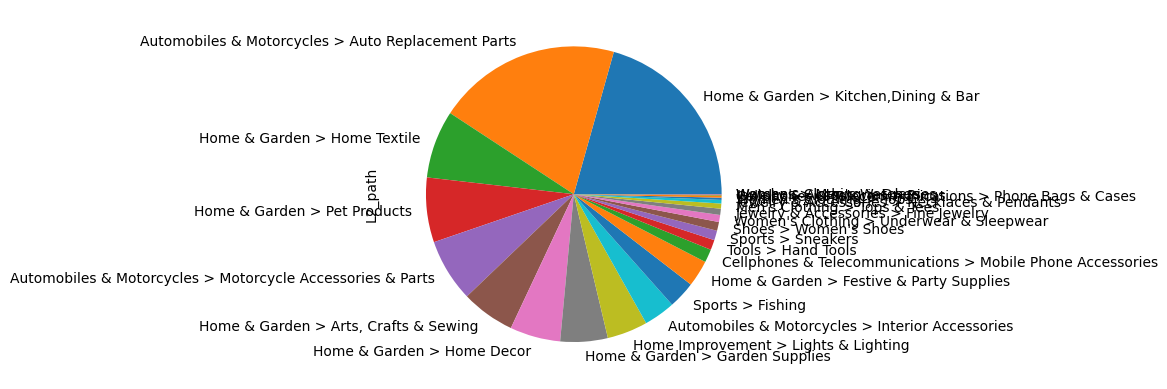

In [104]:
df_products['L2_path'].value_counts().plot.pie()

In [105]:
len(set(df_products['L2_path']))

25

In [107]:
df_products['L2_path'].value_counts().max(), df_products['L2_path'].value_counts().min()

(8428, 17)

In [110]:
df_l2_stratified_sample = df_products.groupby('L2_path').sample(10, random_state=42)

<AxesSubplot: ylabel='L2_path'>

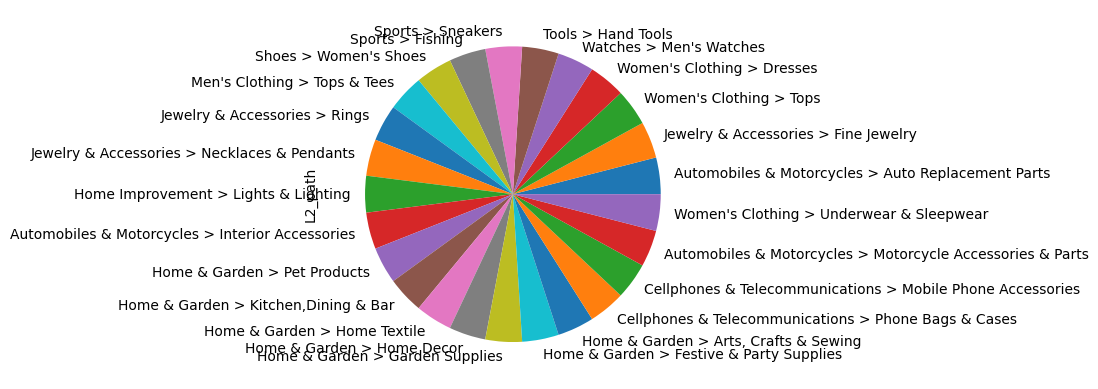

In [111]:
df_l2_stratified_sample['L2_path'].value_counts().plot.pie()

In [115]:
df_l2_stratified_sample["temp_img_url"] = df_l2_stratified_sample['product_id'].apply(
    lambda x: f"https://contestimg.wish.com/api/webimage/{x}-large.jpg").tolist()

In [121]:
len(df_l2_stratified_sample)

250

In [122]:
df_l2_stratified_sample.to_csv("[data] appen_data_tester_size_250_stratified_by_l2_20221229.csv", index=False)